In [542]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
import itertools

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer

from scipy.sparse.linalg import norm

%matplotlib inline
import matplotlib.pyplot as plt

from df_builder_mini_cleaner import *

# Creating the DataFrame

In [818]:
cnn_df = pd.read_csv('data/cnn.csv')
fox_df = pd.read_csv('data/fox.csv')
onion_df = pd.read_csv('data/onion_csv.csv')

In [819]:
df_final = build_df(onion_df, fox_df, cnn_df)

In [820]:
df_final

,Article,Satire,CNN,Fox
0,washington in a statement confirming his suppo...,1,0,0
1,washington irked that the attorney general’s b...,1,0,0
2,stamford ct lamenting that the numbers were mu...,1,0,0
3,nairobi kenya warning that a complete overhaul...,1,0,0
4,napa ca after being lovingly tended by generat...,1,0,0
5,pineville la citing concerns over historically...,1,0,0
6,cambridge ma warning that nothing was more dan...,1,0,0
7,south bend in stumbling through the restaurant...,1,0,0
8,heaven speaking with obvious nostalgia regardi...,1,0,0
9,cary nc competing to secure the new pet’s alle...,1,0,0


In [821]:
def find_short_articles(content_list):
    '''
    Takes in a list of articles that is a list of strings
    and then returns article len for each article.
    input: list of strings
    output: list of article lengths
    '''
    
    count = 0
    words = 0
    
    
    # Come back for more preprocessing
    # Right now this is just a rough estimate
    # because the numbers in the articles are messing up
    # the count
    # (), "" are also messing up the count
    article_len=[]
    for x in content_list:
        length = len(x.split()) 
        article_len.append(str(length))
    return article_len

In [798]:
sooner = find_short_articles(list(df_final.Article))

In [822]:
def short_index(article_lengths):
    '''
    Takes in a list of article lengths and returns a list of indices where the article has less than 
    50 words
    input: list of article lengths
    output: list of indices corresponding to the short articles
    '''
    count = 0
    idx_list = []
    for idx, art in enumerate(article_lengths):
        if int(art) < 50:
            idx_list.append(idx)
            count+=1
    return idx_list

In [823]:
boom_idx_list = short_index(find_short_articles(list(df_final.Article)))

In [824]:
len(boom_idx_list)

134

In [825]:
df_final_short = df_final.drop(idx_list)

In [826]:
df_final.Satire.sum()

5000

In [827]:
df_final_short.Satire.sum()

4927

### More Cleaning

In [830]:
def new_cleaner(df):
    '''
    Removes more features like punctuation and words that
    should not be in there
    Input: df_final
    output: df_final with cleaned articles
    '''
    article_list = list(df_final_short.Article)
    clean_list = []
    for article in article_list:
        samp1 = re.sub('[''\”\“\‘;:\'\'\'•·%$!&+}{|><_…/\’]', '', article)
        samp2 = re.sub('[-—]', ' ', samp1)
        samp3 = samp2.replace('news','')
        clean_list.append(samp3.replace('fox',''))
    df['Article'] = clean_list
    return df

In [831]:
new_df_final = new_cleaner(df_final_short)

# Word Count

In [833]:
def word_count(content_list):
    '''
    Takes in a list of fox articles that is a list of strings
    and then returns an average word count for each article.
    input: list of strings
    output: average word count per article
    '''
    
    count = 0
    words = 0
    
    
    # Come back for more preprocessing
    # Right now this is just a rough estimate
    # because the numbers in the articles are messing up
    # the count
    # (), "" are also messing up the count
    for x in content_list:
        length = len(x.split()) 
        words += length
        count += 1
    print(count)
    print(words)
    print(words/count)
    return words/count

In [871]:
onion_word_count = word_count(list(df_final_short.Article[0:(df_final_short.Satire.sum())]))

4927
923711
187.4793992287396


In [887]:
cnn_word_count = word_count(list(df_final_short.Article[4927:9927]))

5000
3685941
737.1882


In [892]:
fox_word_count = word_count(list(df_final_short.Article[9927:]))

4354
2248544
516.431786862655


In [893]:
word_counts_df = pd.DataFrame([['Onion', onion_word_count], ['CNN', cnn_word_count], ['Fox', fox_word_count]], columns=['Source', 'Average_Word_Count'])

Text(0.5, 0, 'Source')

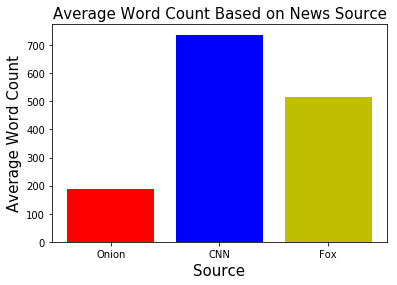

In [894]:
fig, ax = plt.subplots()
plt.bar(word_counts_df.Source.values,word_counts_df.Average_Word_Count, color ='rby')
ax.set_title("Average Word Count Based on News Source", fontsize = 15)
ax.set_ylabel("Average Word Count", fontsize = 15)
ax.set_xlabel("Source", fontsize = 15)

# Models

### Tokenizing and Stemming

In [895]:
porter = PorterStemmer()

In [840]:
def tokenize(doc):
    return [porter.stem(word) for word in word_tokenize(doc)]

### Train Test Split

In [841]:
docs_train, docs_test, y_train, y_test = train_test_split(new_df_final['Article'], new_df_final['Satire'])

### TFIDF Vectorization 

In [842]:
cust_stop_words = ['serious', 'any', 'ours', 'go', 'do','else', 'while', 'somehow', 'seem', 'front', 'thick', 'once', 'system', 'latter', 'amongst', 'hence', 'un',
 'cannot', 'more', 'eight', 'he', 'seems', 'it', 'hereafter', 'last', 'here', 'beyond', 'because', 'few', 'fill',
 'his', 'further', 'sincere', 'their', 'made', 'fifty', 'whatever', 'whenever', 'been', 'describe', 'otherwise', 'or',
 'our', 'move', 'eg', 'over', 'per', 'amoungst', 'perhaps', 'you', 'beside', 'hundred', 'across', 'which',
 'where', 'anyone', 'anywhere', 'name', 'several', 'a', 'no', 'whence', 'mostly', 'so', 'call', 'seemed', 'everyone',
 'these', 'besides', 'whom', 'whereby', 'eleven', 'thereupon', 'twelve', 'when', 'former', 'most', 'therein', 'had',
 'hasnt', 'yourself', 'next', 'being', 'wherein', 'only', 'them', 'third', 'mine', 'show', 'nobody',
 'sometimes', 'somewhere', 'still', 'were', 'with', 'became', 'how', 'yourselves', 'her', 'much', 'ltd', 'as', 'those',
 'done', 'twenty', 'along', 'get', 'herself', 'interest', 'nor', 'however', 'same', 'side', 'whole', 'namely',
 'might', 'if', 'has', 'up', 'both', 'not', 'bottom', 'ourselves', 'via', 'whither', 'fifteen', 'your', 'mill', 'someone', 'even',
 'please', 'thus', 'under', 'are', 'in', 'etc', 'anyhow', 'after', 'hereupon', 'my', 'from', 'through', 'before', 'own', 'against', 'below', 'throughout', 'although', 'herein',
 'himself', 'noone', 'will', 'also', 'thru', 'out', 'keep', 'something', 'there', 'nevertheless', 'nine', 'always',
 'except', 'almost', 'some', 'couldnt', 'hereby', 'indeed', 'detail', 'moreover', 'hers', 're', 'all', 'six',
 'themselves', 'two', 'already', 'forty', 'thereby', 'become', 'each', 'thence', 'within', 'nowhere', 'by', 'due', 'full', 'thin', 'us', 'anyway', 'other', 'among', 'this', 'though', 'without', 'then', 'five', 'another', 'first', 'myself', 'every', 'at', 'de', 'toward',
'whereafter', 'alone', 'beforehand', 'amount', 'ie', 'meanwhile', 'behind', 'must', 'now', 'others',
 'many', 'be', 'con', 'an', 'formerly', 'everywhere', 'therefore', 'find', 'to', 'together', 'could', 'elsewhere', 'about', 'three', 'am', 'since', 'me', 'whose', 'ever', 'cry', 'becoming', 'whereas', 'see', 'well', 'back', 'everything', 'nothing', 'whether', 'itself',
 'whoever', 'often', 'never', 'down', 'top', 'least', 'too', 'of', 'during', 'inc', 'less', 'that', 'she', 'give', 'than',
 'latterly', 'they', 'fire', 'found', 'the', 'bill', 'thereafter', 'enough', 'very', 'have', 'its', 'who', 'anything',
 'afterwards', 'around', 'upon', 'but', 'either', 'again', 'should', 'what', 'into', 'none', 'would', 'can', 'for', 'put', 'empty', 'why', 'is', 'him',
 'above', 'between', 'four', 'off', 'cant', 'may', 'sometime', 'until', 'and', 'part', 'yet', 'onto', 'towards','neither',
 'yours', 'we', 'take', 'rather', 'on', 'such', 'was', 'ten', 'becomes', 'co', 'one', 'i', 'seeming', 'wherever','whereupon','sixty','abov', 'afterward', 
'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els',
'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr',
'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 
'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth',
'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 
'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv','anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh']

In [843]:
vect = TfidfVectorizer(stop_words=cust_stop_words, tokenizer=tokenize, min_df=3)
X_train = vect.fit_transform(docs_train)
X_test = vect.transform(docs_test)

### Logistic Regression Model

In [846]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/Users/jphooster22/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [847]:
log_reg_y_pred = log_reg.predict(X_test)
log_reg_con_mat = confusion_matrix(y_test, log_reg_y_pred)
recall_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[1,0])
prec_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[0,1])
F1_log_reg = ((prec_log_reg*recall_log_reg)/(prec_log_reg+recall_log_reg))*2
F1_log_reg

0.9680808080808082

### Naive Bayes Model

In [848]:
na_ba = MultinomialNB(alpha=.1)
na_ba.fit(X_train, y_train)



MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [849]:
na_ba_pred = na_ba.predict(X_test)
na_ba_con_mat = confusion_matrix(y_test, na_ba_pred)
recall_na_ba= na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[1,0])
prec_na_ba = na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[0,1])
F1_na_ba = ((prec_na_ba*recall_na_ba)/(prec_na_ba+recall_na_ba))*2
F1_na_ba

0.8932838895756076

# Data Vis for Models

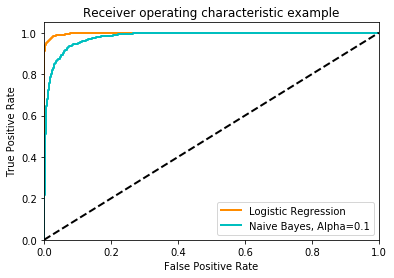

In [850]:
roc_log_reg  = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1], pos_label=1)
roc_na_ba  = roc_curve(y_test, na_ba.predict_proba(X_test)[:,1], pos_label=1)
plt.figure()
lw = 2
plt.plot(roc_log_reg[0], roc_log_reg[1], color='darkorange',
         lw=lw, label='Logistic Regression')

plt.plot(roc_na_ba[0], roc_na_ba[1], color='c',
         lw=lw, label='Naive Bayes, Alpha=0.1')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [851]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[2294   27]
 [  52 1198]]


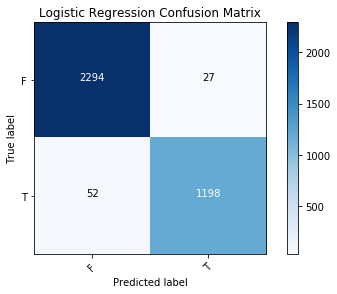

In [852]:
plot_confusion_matrix(log_reg_con_mat,['F','T'], title='Logistic Regression Confusion Matrix')

Confusion matrix
[[2228   93]
 [ 166 1084]]


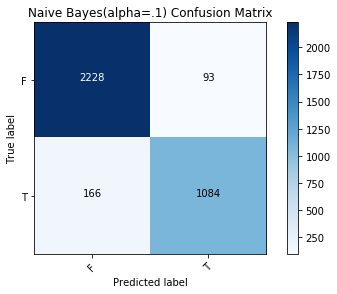

In [853]:
plot_confusion_matrix(na_ba_con_mat,['F','T'], title='Naive Bayes(alpha=.1) Confusion Matrix')

# Feature Exploration

In [854]:
features = vect.get_feature_names()

log_reg_coef = log_reg.coef_.reshape(log_reg.coef_.shape[1],)

In [855]:
log_reg.coef_.shape[1]

21137

In [856]:
len(features), len(log_reg_coef)

(21137, 21137)

In [857]:
feature_df = pd.DataFrame(features)

In [858]:
feature_df

,0
0,#
1,''
2,*
3,**
4,**want
5,0
6,00
7,000
8,000th
9,001


In [859]:
feature_df['Beta_Coef'] = log_reg_coef
feature_df['Word'] = feature_df[0]

In [860]:
beta_feature_df = feature_df[['Beta_Coef', 'Word']]

In [861]:
sort = beta_feature_df.sort_values('Beta_Coef')

In [862]:
sort

,Beta_Coef,Word
16369,-5.917889,said
19326,-4.742217,trump
16314,-4.086913,s
14571,-3.848436,polic
19042,-3.845215,told
7,-3.827308,000
1010,-3.613325,accord
19445,-3.252264,u
4197,-2.978849,clinton
14172,-2.852171,peopl


In [863]:
bot_10=list(sort['Beta_Coef'][0:10])
top_10=list(sort['Beta_Coef'][-10:])
bot_top = bot_10 +top_10

In [864]:
bot_10_words = list(sort['Word'][0:10])
top_10_words = list(sort['Word'][-10:])
top_bot_words = bot_10_words + top_10_words

Text(0.5, 0, 'Word')

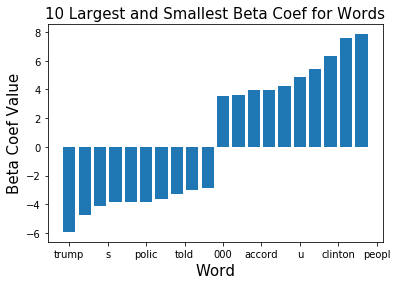

In [865]:
data = bot_top
labels = top_bot_words
fig, ax = plt.subplots()

plt.bar(np.arange(len(data)), data)
#ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(labels)
ax.set_title("10 Largest and Smallest Beta Coef for Words", fontsize = 15)
ax.set_ylabel("Beta Coef Value", fontsize = 15)
ax.set_xlabel("Word", fontsize = 15)

### Average Magnitude of TFIDF Vector for Satire and News

In [866]:
def avg_tfidf_mag(X_train_vect, y_train):
    '''
    Calculates the average magnitude of the TFIDF vector for Satire and News 
    categories
    input: sparse matrix for training
    '''
    row_norms=[]
    for row in X_train:
        row_norms.append(norm(row))
    sums_arr =np.array(row_norms)
    ytr_arr = np.array(y_train)
    tot_sat_art = np.sum(ytr_arr)
    tot_news_art = len(ytr_arr) - tot_sat_art
    Sat_avg_mag = sums_arr[ytr_arr==1].sum()/tot_sat_art
    News_avg_mag = sums_arr[ytr_arr==0].sum()/tot_news_art
    return Sat_avg_mag, News_avg_mag

In [867]:
Satire_mag, News_mag = avg_tfidf_mag(X_train, y_train)

In [868]:
Satire_mag, News_mag

(1.0, 0.9995734394995024)

Text(0.5, 0, 'Type of Article')

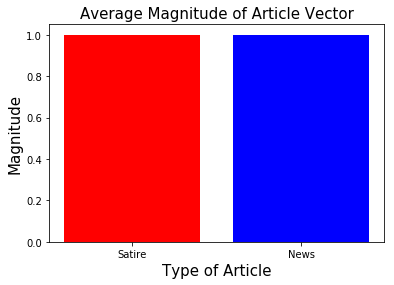

In [869]:
fig, ax = plt.subplots()
plt.bar(['Satire', 'News'],[Satire_mag, News_mag], color ='rby')
ax.set_title("Average Magnitude of Article Vector", fontsize = 15)
ax.set_ylabel("Magnitude", fontsize = 15)
ax.set_xlabel("Type of Article", fontsize = 15)

### SVD